<a href="https://colab.research.google.com/github/JielingChen/optimizing_conversion_rate/blob/main/Optimizing_Conversion_Rate_Part_2_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).  

# Goal
The goal of this project:
* __Build a model that predicts conversion rate__
* __Come up with recommendations for the product team and the marketing team to improve conversion rate__

# Data
Columns:
* `country` : user country based on the IP address
* `age` : user age. Self-reported at sign-in step
* `new_user` : whether the user created the account during this session or had already an account and simply came back to the site
* `source` : marketing channel source
  1. Ads: came to the site by clicking on an advertisement
  2. Seo: came to the site by clicking on search results
  3. Direct: came to the site by directly typing the URL on the browser
* `total_pages_visited`: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* `converted`: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

__This notebook is the second part of this project.__  

## 0. Importing Data Set

In [15]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# read data
data = pd.read_csv('/content/conversion_data.csv')
print(len(data))
data.head()

316200


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [17]:
# remove the out of range data
data = data[data['age'] < 100]
len(data)

316198

## 1. Defining the Problem
Since our first goal is to predict the conversion rate, which can be translated into predicting whether a specific user will convert or not, we can define our problem as a __binary classification problem.__

## 2. Machine Learning Models
The logistic regression model is a common model for benchmarking performance for a binary classification problem.  

Logistic Regression is a linear model. The model learns a set of weights that are used to make predictions about the probability of the outcome. The model makes predictions using the logistic function, which maps the input data to a range of 0 to 1. This range represents the probability of the outcome, with 0 representing a low probability and 1 representing a high probability. The weights are learned using an optimization algorithm, such as gradient descent, that minimizes the error between the predicted probabilities and the true outcomes. It's a great choice for generating a baseline for any binary classification problem.

We will use the logistic regression model to predict the conversion rate.


## 3. Preprocessing Data for Machine Learning

### 3.1 Data Format

Since we are going to use scikit-learn to do machine learning, firstly we need to make sure the data set meets the requirements of scikit-learn:
* No missing values
* Data in numeric format
* Data stored in pandas DataFrame or Numpy array

#### 3.1.1 Missing Data

In [18]:
# Check if there are any null values
data.isna().any()

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

As we have already seen in part 1, we don't have any missing data in our data set.

#### 3.1.2 Categorical Data
Categorical variables can be encoded in a variety of ways:
* __One-hot encoding:__ This method creates a new binary column for each category and encodes the categories as 0 or 1. In One-hot encoding each category will have its own weight that can be observed after training. But we must be aware that One-hot encoding may create features that are entirely collinear due to the same information being represented multiple times.

* __Dummy encoding:__ This method is very similar to One-hot encoding, but only creates n-1 features for n categories, omitting the first category. It can represent necessary information without duplication.
* __Ordinal encoding:__ This method encodes each category as a unique integer. This can be useful if the categorical variable has a natural ordering, as the integers will capture the ordinal relationship between the categories. For example, if a categorical variable has three categories low, medium and high, it could be encoded as 1, 2 and 3 respectively. However, it is important to note that the integer values have a meaningful order, and they should not be treated as continuous variables.
* __Binary encoding:__ This method encodes each category as a binary vector, with the vector elements representing the presence or absence of a particular category. This can be a more efficient encoding than one-hot encoding, as it results in a lower-dimensional dataset.

Since our categorical features are `country` and `source`, with 4 and 3 different categories respectively and no ordinal pattern, we can use One-hot encoding which will allow us to observe the coefficients for every category after training.

In [19]:
# encode the categorical data
data = pd.get_dummies(data, prefix=['C', 'S'], columns=['country', 'source'])
data.head()

,age,new_user,total_pages_visited,converted,C_China,C_Germany,C_UK,C_US,S_Ads,S_Direct,S_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


### 3.2 Data Distribution
An important consideration before building a machine learning model is to understand what the distribution of the data looks like. A lot of algorithms make assumptions about how the data is distributed.   

Many machine learning algorithms make assumptions of normality and equal variance. Almost all models besides tree-based models require the features to be on the same scale.  

Checking the distribution of the data can help us identify issues violating these assumptions such as outliers, skewness, high variance and different scales. These issues can affect the performance of the model and should be addressed before training the model.

#### 3.2.1 Inspecting Outliers
Outliers are observations in the data that are significantly different from the rest of the data points. They can have a disproportionate effect on the results of a machine learning model, and can skew the distribution of the data.

There are several reasons why it's important to remove outliers before training a model:

* Outliers can affect the accuracy of the model by introducing bias in the data, leading to unreliable or inaccurate predictions.  

* Outliers can affect the stability of the model, causing the model to overfit or underfit the data.  

* Outliers can affect the interpretability of the model, making it more difficult to understand the relationships between variables and the overall model.  

* Outliers can affect the performance of the model, in some cases, the algorithm may be sensitive to the outliers, and it will get affected by the extreme values.  

It's worth noting that not all outliers should be removed:
* Some of them can carry valuable information and removing them can lead to lose important information and reduce the performance of the model.
* Removing outliers before training a model can improve the performance of the model on the training data, but it can also make the model less robust to outliers in the real world. 

In such cases, it may be better to keep the outliers, and instead try to find ways to account for them in the model. It's important to thoroughly examine the outliers and make an informed decision about whether to remove or keep them, and how to handle them in the model.

Let's detect outliers in `age` column and decide whether we should keep them.  We can use Z-score method to detect outliers. This method calculates the number of standard deviations away from the mean a data point is. Data points that have a z-score greater than a certain threshold (usually 3 or -3) are considered outliers.

In [20]:
# use Z-score method to detect outliers
mean = data['age'].mean()
std = data['age'].std()
cutoff = std * 3 
lower, upper = mean - cutoff, mean + cutoff
print('The lower bound of age is:', lower)
print('The upper bound of age is:', upper)
outliers = data[(data['age'] > upper) | (data['age'] < lower)]

The lower bound of age is: 5.762438212070137
The upper bound of age is: 55.37618379059908


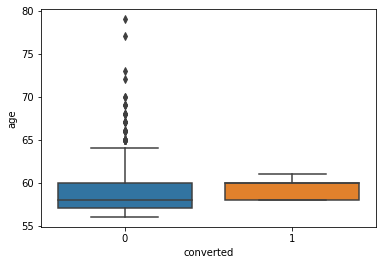

In [21]:
# examine the outliers through visualization
sns.boxplot(x='converted', y='age', data=outliers)
plt.show()

We can see from the box plot that age does carry some information about conversion, and it's very common in the real world that a user's age is above 55 years old, so we decide not to remove the outliers in order to make our model robust to real-world situations and unbiased.

#### 3.2.2 Variance and Skewness
When we are working with any kind of model that uses a linear distance metric or operates in a linear space like k-nearest neighbors, logistic regression, or k-means clustering, the model is assuming that the data and features we are giving it are related in a linear fashion, or can be measured with a linear distance metric.   

When a feature or features in the dataset have high variance, it could bias a model that assumes the data is normally distributed. If a feature in the dataset has a variance that's an order of magnitude or more greater than the other features, this could impact the model's ability to learn from other features in the dataset.

Skewed data can also have a significant impact on linear machine learning models. When the data is skewed, the majority of the data points will be concentrated in a small range of the feature space, while a few data points will have much larger values. This can cause issues for linear models because they assume that the data is approximately normally distributed and that the data points are evenly spread across the feature space.

Let's check the variance and skewness of our data.

In [22]:
# check the variance of features
data.var()

age                    68.375660
new_user                0.215602
total_pages_visited    11.162637
converted               0.031212
C_China                 0.183570
C_Germany               0.039583
C_UK                    0.129747
C_US                    0.246003
S_Ads                   0.201883
S_Direct                0.176578
S_Seo                   0.249907
dtype: float64

We can see that `age` column and `total_pages_visited` have relatively high variances.

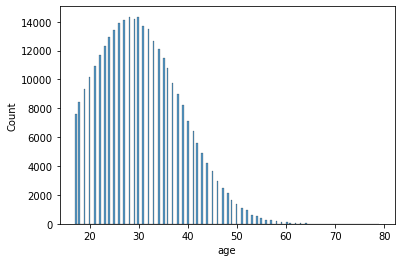

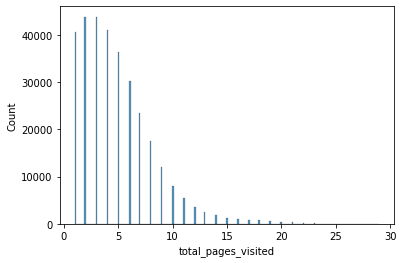

In [23]:
# check the skewness of age and total_pages_visited
sns.histplot(data=data, x='age')
plt.show()
sns.histplot(data=data, x='total_pages_visited')
plt.show()

We can see from the graphs that both `age` and `total_pages_visited` are right-skewed.

##### 3.2.2.1 Log Transformation
Log transformation is a nice way to minimize the variance of a column and make it less skewed. It takes the natural log and transforms values onto a scale that approximates normality. It is a good strategy when you care about relative changes in a linear model and you still want to capture the magnitude of change. 

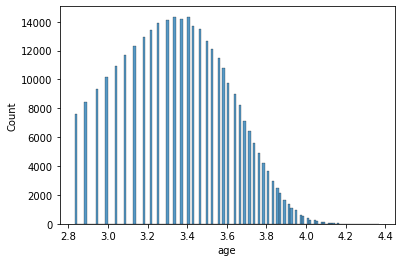

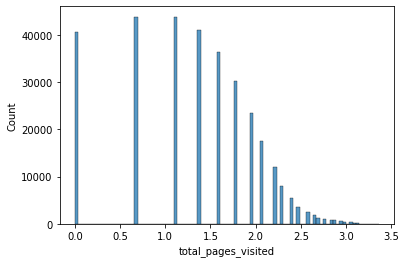

In [24]:
# log transformation
data['age'] = np.log(data['age'])
data['total_pages_visited'] = np.log(data['total_pages_visited'])

# check the data after transformation
data.var()
sns.histplot(data['age'])
plt.show()
sns.histplot(data['total_pages_visited'])
plt.show()

After log transformation, the variances are more equal and the distributions are closer to normality.

### 3.2.3 Scaling
It is obvious that our data set contains continuous features that are on different scales: `age` and `total_pages_visited`. This will negatively impact the performance of linearity-based models, such as logistic regression and k-Nearest Neighbors. We will need to transform the data into comparable scales before we put it into the linearity-based models.

There are two common ways to scale data: `StandardScaler` and `MinMaxScaler`. Both scalers change the range of feature values to make them linearly comparable to prevent some features from dominating others, while do not change the shape of the distribution of the data, so we won't lose information about the features. 

* __`StandardScaler`__ standardizes the features of a dataset so that they have the properties of a standard normal distribution (mean of 0 and standard deviation of 1). This is done by subtracting the mean of each feature from each data point and dividing it by the standard deviation of the feature. 

* __`MinMaxScaler`__ scales the features of a dataset to a specific range, usually 0 to 1. It does this by subtracting the minimum value of the feature from each data point and dividing the difference between the minimum and maximum values.

We can try both of them on our data to see which one performs better.

To avoid data leakage, we need to split our data set into a training set and a testing set before we perform further processing.  
We noticed in EDA that only 3.2% of the users were converted. When labels have an uneven distribution, we need to use stratified sampling.

In [26]:
# Split the data into two DataFrames: X (features) and y (target variable)
y = data['converted']
X = data.drop('converted', axis=1)
print(y.head())
print(X.head())

0    0
1    0
2    0
3    0
4    0
Name: converted, dtype: int64
        age  new_user  total_pages_visited  C_China  C_Germany  C_UK  C_US  \
0  3.218876         1             0.000000        0          0     1     0   
1  3.135494         1             1.609438        0          0     0     1   
2  3.332205         1             1.386294        0          0     0     1   
3  3.663562         1             1.609438        1          0     0     0   
4  3.401197         1             1.791759        0          0     0     1   

   S_Ads  S_Direct  S_Seo  
0      1         0      0  
1      0         0      1  
2      0         0      1  
3      0         0      1  
4      0         0      1  


In [27]:
from sklearn.model_selection import train_test_split
seed = 1

# Split the data into train and test subsets and stratified sampling the test data size to be 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Scaling X data based on X_train using 2 different scalers
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

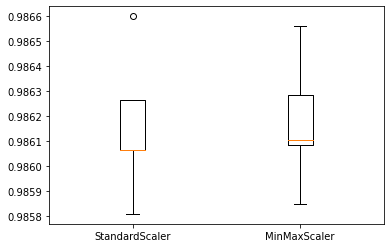

In [31]:
# check which scaler performs better using cross-validation
kf = KFold(n_splits=5, random_state=seed, shuffle=True)

lr_standard = LogisticRegression(random_state=seed)
cv_results_standard = cross_val_score(lr_standard, X_train_standard, y_train, cv=kf)

lr_minmax= LogisticRegression(random_state=seed)
cv_results_minmax = cross_val_score(lr_minmax, X_train_minmax, y_train, cv=kf)

plt.boxplot([cv_results_standard,cv_results_minmax], labels=['StandardScaler', 'MinMaxScaler'])
plt.show()

The results are pretty close. `MinMaxScaler` is slightly better than `StandardScaler`, so we can choose `MinMaxScaler` as our scaler.

## 4. Hyperparameter Tuning
In machine learning, a model's performance can be heavily influenced by the values of its hyperparameters. These hyperparameters are set before training the model and are not learned during training.  

Hyperparameter tuning is the process of selecting the optimal values for the hyperparameters of a machine learning model. Here we use `GridSearch` for hyperparameter tuning since the data set isn't very large. `GridSearchCV` can perform an exhaustive search of the specified hyperparameters by training the model with different combinations of hyperparameter values and evaluating its performance using a specified scoring metric. It then returns the combination of hyperparameter values that result in the best performance.

In logistic regression, the common hyperparameters to tune are the type of regularization (penalty), the regularization strength (C), and the algorithm to use in the optimization problem (solver).

Regularization is a technique to prevent overfitting in machine learning. In linear models, large coefficients can lead to overfitting, so we can use regularization to penalize large coefficients by adding a penalty term to the cost function of the model. 
In logistic regression, the most common regularization method are L1 and L2 regularization. 

* Lasso (L1): Adding a penalty term to the loss function that is proportional to the absolute value of the coefficients (α * sum of absolute coefficient). L1 regularization can set many of the coefficients to zero, thus ignoring those features. In other words, L1 can perform feature selection. 

* Ridge (L2): Adding a penalty term to the loss function that is proportional to the square of the coefficients (α * sum of squared coefficient). L2 regularization shrinks the coefficients to be smaller.

"C" is the inverse of the regularization strength (α). Hence, a larger C means less regularization and a smaller C means more regularization.


*We* can first create a learning curve of regularization strength to determine the range of `C` used in GridSearch.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

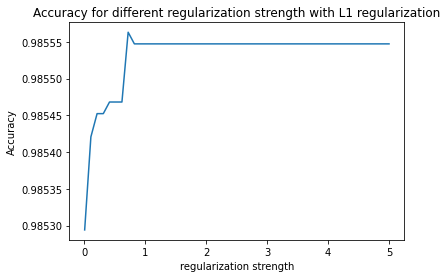

In [34]:
# Set the regularization strength & accuracies list
C = np.linspace(0.01, 5, num=50)
accuracies = []

# Create the for loop
for c in C:
  	# Create the model with L1 regularization, predictions & save the accuracies
    model = LogisticRegression(C=c, penalty='l1', solver='saga')
    predictions = model.fit(X_train_minmax, y_train).predict(X_test_minmax)
    accuracies.append(accuracy_score(y_test, predictions))

# Plot results    
plt.plot(C, accuracies)
plt.gca().set(xlabel='regularization strength', ylabel='Accuracy', title='Accuracy for different regularization strength with L1 regularization')
plt.show()

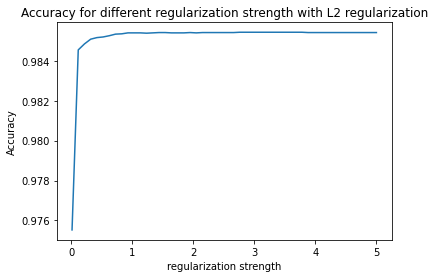

In [35]:
# Set the regularization strength & accuracies list
C = np.linspace(0.01, 5, num=50)
accuracies = []

# Create the for loop
for c in C:
  	# Create the model with L2 regularization, predictions & save the accuracies
    model = LogisticRegression(C=c, penalty='l2')
    predictions = model.fit(X_train_minmax, y_train).predict(X_test_minmax)
    accuracies.append(accuracy_score(y_test, predictions))

# Plot results    
plt.plot(C, accuracies)
plt.gca().set(xlabel='regularization strength', ylabel='Accuracy', title='Accuracy for different regularization strength with L2 regularization')
plt.show()

Both of the accuracies increase significantly from 0.0 - 1.0, then stay stable, so we can narrow down our grid search region of C to 0.5 - 2.0.

In [36]:
# Define the parameter grid
param_grid = {'C': [0.5, 1, 1.5, 2],
              'penalty': ['l1'],
              'solver':['saga']}

# Create a logistic regression model
log_reg = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_minmax, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best score:  0.986179525231873


In [37]:
# Define the parameter grid
param_grid = {'C': [0.5, 1, 1.5, 2],
              'penalty': ['l2'],
              'solver':['lbfgs','newton-cg', 'sag', 'saga']}

# Create a logistic regression model
log_reg = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_minmax, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 1.5, 'penalty': 'l2', 'solver': 'sag'}
Best score:  0.9861676656493303


We can also choose not to use regularization in our model and see its performance.

In [38]:
# Define the parameter grid
param_grid = {'penalty': ['none'],
              'solver':['lbfgs','newton-cg', 'sag', 'saga']}

# Create a logistic regression model
log_reg = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_minmax, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'penalty': 'none', 'solver': 'lbfgs'}
Best score:  0.9861637124551494


We can see that the combination of parameters {'C': 1, 'penalty': 'l1', 'solver': 'saga'} has the highest score (0.986179). We will use these hyperparameters to set our model for training and testing.

## 5. Model Validation
There are several metrics that can be used to evaluate the performance of a binary classification model. Some common metrics for binary classification are:

__Accuracy:__ This is the number of __correct predictions made by the model__, expressed as a percentage of the total number of predictions.  

__Precision:__ This is the number of true positive predictions made by the model, expressed as a percentage of the total number of positive predictions made by the model. Precision is a measure of the model's __ability to avoid false positives__.  

__Recall:__ This is the number of true positive predictions made by the model, expressed as a percentage of the total number of positive cases in the data. Recall is a measure of the model's __ability to identify all positive cases__.  

__F1 score:__ This is the harmonic mean of precision and recall. The F1 score is a good metric to use when you want to __balance precision and recall__.  

__ROC curve:__ This is a graphical plot that illustrates the __performance of a binary classification model for all possible classification thresholds__. The plot shows the true positive rate (recall) on the y-axis and the false positive rate on the x-axis. The area under the ROC curve (AUC) is a measure of the model's overall performance. __The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.__  

It is important to choose the appropriate metric for the task at hand. For example, if the goal is to identify all positive cases, then recall may be the most important metric to focus on. On the other hand, if the goal is to minimize false positives, then precision may be more important.

First, let's train our model using the training set and do predictions on the testing set.

In [39]:
# train and predict
params = {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
lr_model = LogisticRegression(**params)
y_pred = lr_model.fit(X_train_minmax, y_train).predict(X_test_minmax)

Now let's perform model validation.

In [40]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
)

Accuracy: 0.9855471220746364
Precision: 0.8379351740696278
Recall: 0.6843137254901961
F1-Score: 0.7533729087965462


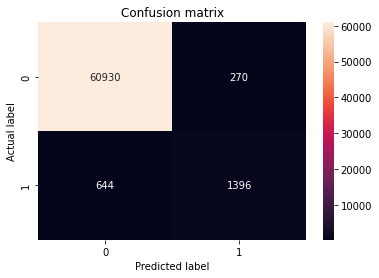

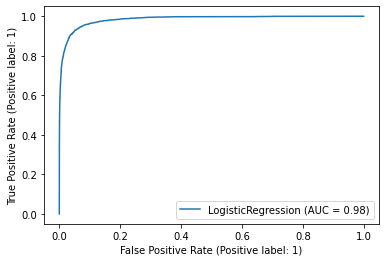

In [41]:
# Calculate the accuracy, precision, and recall scores
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# Calculate confusion matrix
lr_matrix = confusion_matrix(y_test, y_pred)

# Plot a labeled confusion matrix with Seaborn
sns.heatmap(lr_matrix, annot=True, fmt="g")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# Plot ROC curve
RocCurveDisplay.from_estimator(lr_model, X_test_minmax, y_test)

The model achieves a 98.55% accuracy on the testing set. It's close to the accuracy on the training set, indicating the model didn't overfit or underfit.  
The F1-score is 0.7533, and the AUC is 0.98, which are acceptable scores for an imbalanced dataset.


We can check the coefficients of the model to get some insights into how the features affect the conversion.

In [42]:
# match the coefficients and the features
coef = list(lr_model.coef_[0])
features = list(X_train.columns)
coefficients = pd.DataFrame(dict(zip(features, coef)), index=[0])
coefficients

,age,new_user,total_pages_visited,C_China,C_Germany,C_UK,C_US,S_Ads,S_Direct,S_Seo
0,-3.059668,-1.680324,26.351826,-3.430649,0.282308,0.000943,-0.327283,0.044603,-0.174413,-0.000116


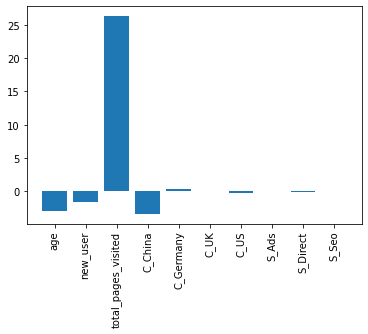

In [43]:
# visualize the coefficients
plt.bar(features, coef)
plt.xticks(rotation=90)
plt.show()

Since we used L1 regularization to train our model, the coefficients of less important features were shrunk to near zero. We can see from the graph that the most important feature is `total_pages_visited`, which has a high positive impact on conversion. `age`, `new_user` and `C_China` have negative impacts on conversion. 

What we found from the coefficient of our model is consistent with what we found in the Exploratory Data Analysis:
* The users who visited more pages on our website are more likely to be converted, and it's the most important feature of the converted users.
* New users, users with older ages, and users from China are less likely to be converted.

## 6. Recommendations for Improving Conversion Rate

Product Team:
* Conduct user research to understand why the conversion rate is higher in Germany compared to other countries, and consider implementing similar strategies in other countries.
* Optimize the website's user experience for users from China, as they have a lower conversion rate compared to other countries.
* Consider implementing a personalized and segmented user experience for new and returning users, as the conversion rate is significantly higher for returning users.
* Monitor the engagement levels of users and explore ways to increase the average number of pages visited per session, as this has a positive correlation with conversion rate.  

Marketing Team:
* Target younger users in marketing campaigns, as the conversion rate is higher for younger users compared to older users.
* Develop and test different ad campaigns targeting users from China, as they have a lower conversion rate compared to other countries.
* Monitor and optimize the performance of the different marketing channels, specifically focus on increasing the conversion rate of the direct source, which currently has the lowest conversion rate.
* Use the most engaging page(s) of the website as a landing page for the different marketing campaigns to increase the conversion rate.

